In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16413392759246771787
]


Load dataset.

In [2]:
past = 4

In [3]:
train, xval, test = src.load_datasets(past_frames=past)

Training data: (7500, 64, 64, 5)
Validation data: (1500, 64, 64, 5)
Test data: (1000, 64, 64, 5)


Split data to inputs and ground truth images.

In [4]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:1000], xval, test, past_frames=past, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 4) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 4) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 4) 
Shape of test truth:  (1000, 64, 64, 1)


Make discriminator labels.

In [5]:
batch_size=64

In [6]:
# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
#Generator ground truths
g_real = np.ones((batch_size, 1))

In [7]:
real, fake = noisy_d_labels(real, fake)

NameError: name 'noisy_d_labels' is not defined

Make generator but don't compile.

In [8]:
generator = src.unet(gan_train.shape[1:], dropout=0, batchnorm=False)

In [9]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4128        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

Make discriminator and compile.

In [10]:
discriminator = src.spatial_discriminator(condition_shape=gan_train.shape[1:], dropout = 0.25, batchnorm=True)
discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

Inputs and outputs of the GAN.

In [11]:
frame_t = keras.layers.Input(shape=gan_train.shape[1:])

In [12]:
frame_t.shape

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(4)])

In [13]:
generated = generator(frame_t)

In [14]:
score = discriminator([frame_t, generated])

Freeze discriminator weights.

In [15]:
discriminator.trainable = False

Compile combined model.

In [16]:
loss_weights=[0.1,1]

In [17]:
combined = keras.models.Model(inputs=[frame_t], outputs=[generated, score])

In [19]:
combined.compile(loss=[src.custom_loss(loss="l1"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights)

***Using L1 loss.***


Train x epochs.

In [20]:
epochs = 100

In [21]:

log = {"g_loss":[],
               "d_loss":[],
               "g_metric":[],
               "d_metric":[],
      "d_loss_real":[],
      "d_loss_fake":[],
      "d_test_real":[],
      "d_test_fake":[]}

In [26]:
for epoch in range(epochs):
    discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx]
        
    generated_imgs = generator.predict(training_batch) 
    d_loss_real = discriminator.train_on_batch([training_batch, real_imgs], real)
    d_loss_fake = discriminator.train_on_batch([training_batch, generated_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
     #for l in discriminator.layers:
     #   weights = l.get_weights()
     #   weights = [np.clip(w, -clip_value, clip_value) for w in weights] 
     #   l.set_weights(weights)
    
    #d_test_real = discriminator.predict([training_batch, real_imgs])
    #d_test_fake = discriminator.predict([training_batch, generated_imgs])
    discriminator.trainable = False    
    idx = np.random.randint(0, gan_train.shape[0], batch_size)
    training_batch = gan_train[idx]
    training_truth = gan_truth[idx]
    
    g_loss = combined.train_on_batch(training_batch, [training_truth, g_real])
    
    if g_loss[1] < 0.12 and loss_weights[0] > 2**(-1):
        loss_weights[0] /= 2
        combined.compile(loss=[src.custom_loss(loss="l1"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights)
    
    log["g_loss"].append(g_loss)
    log["d_loss_real"].append(d_loss_real[0])
    log["d_loss_fake"].append(d_loss_fake[0])
    #log["d_test_real"].append(d_test_real)
    #log["d_test_fake"].append(d_test_fake)
    log["d_loss"].append(d_loss[0])
    log["d_metric"].append(d_loss[1])
    print(f"\033[1m {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]\033[0m"+
                  f"\033[1m[G loss: {g_loss[0]}, G obj.: {g_loss[1]}, G bce.: {g_loss[2]}]\033[0m")
    print(f"real loss: {d_loss_real}, fake loss: {d_loss_fake}")
    #print(f"test real acc.: {np.mean(d_test_real)}, test fake acc.: {np.mean(d_test_fake)}")
    if epoch%10 == 0:
        sample_images(epoch, gan_test, gan_test_truth, past)

 0 [D loss: 1.1088398694992065, acc.: 20.3125][G loss: 1.0761208534240723, G obj.: 0.16393080353736877, G bce.: 1.0597277879714966]
real loss: [1.1445358, 0.234375], fake loss: [1.073144, 0.171875]
 1 [D loss: 1.0602788925170898, acc.: 19.53125][G loss: 1.1862636804580688, G obj.: 0.15217742323875427, G bce.: 1.1710458993911743]
real loss: [1.0310283, 0.234375], fake loss: [1.0895296, 0.15625]
 2 [D loss: 1.2423008680343628, acc.: 7.8125][G loss: 1.1620651483535767, G obj.: 0.13077087700366974, G bce.: 1.1489880084991455]
real loss: [1.2520127, 0.078125], fake loss: [1.232589, 0.078125]
 3 [D loss: 1.095888376235962, acc.: 17.96875][G loss: 1.0398706197738647, G obj.: 0.14155927300453186, G bce.: 1.025714635848999]
real loss: [1.121751, 0.1875], fake loss: [1.0700259, 0.171875]
 4 [D loss: 1.0709245204925537, acc.: 17.96875][G loss: 1.1045937538146973, G obj.: 0.14502984285354614, G bce.: 1.0900907516479492]
real loss: [1.0342063, 0.203125], fake loss: [1.1076429, 0.15625]
 5 [D loss: 

 39 [D loss: 1.0948066711425781, acc.: 17.1875][G loss: 1.0112416744232178, G obj.: 0.12209728360176086, G bce.: 0.9990319013595581]
real loss: [1.1359468, 0.15625], fake loss: [1.0536665, 0.1875]
 40 [D loss: 1.0481841564178467, acc.: 17.96875][G loss: 1.1266789436340332, G obj.: 0.12816926836967468, G bce.: 1.1138620376586914]
real loss: [1.0485133, 0.171875], fake loss: [1.0478549, 0.1875]
 41 [D loss: 1.0548927783966064, acc.: 19.53125][G loss: 1.095626711845398, G obj.: 0.12098124623298645, G bce.: 1.0835286378860474]
real loss: [1.093347, 0.171875], fake loss: [1.0164387, 0.21875]
 42 [D loss: 1.0362701416015625, acc.: 11.71875][G loss: 1.0387377738952637, G obj.: 0.1233779639005661, G bce.: 1.0263999700546265]
real loss: [1.0194216, 0.09375], fake loss: [1.0531187, 0.140625]
 43 [D loss: 1.00376296043396, acc.: 27.34375][G loss: 1.1024136543273926, G obj.: 0.11374753713607788, G bce.: 1.0910389423370361]
real loss: [0.994856, 0.265625], fake loss: [1.01267, 0.28125]
 44 [D loss:

 78 [D loss: 0.9808628559112549, acc.: 21.09375][G loss: 1.061607837677002, G obj.: 0.17439155280590057, G bce.: 1.0441687107086182]
real loss: [0.97481096, 0.234375], fake loss: [0.9869147, 0.1875]
 79 [D loss: 0.994084894657135, acc.: 18.75][G loss: 0.9595310688018799, G obj.: 0.1582246571779251, G bce.: 0.943708598613739]
real loss: [1.0515364, 0.15625], fake loss: [0.93663335, 0.21875]
 80 [D loss: 1.023301124572754, acc.: 14.84375][G loss: 1.0416136980056763, G obj.: 0.14561475813388824, G bce.: 1.0270521640777588]
real loss: [0.9655509, 0.203125], fake loss: [1.0810515, 0.09375]
 81 [D loss: 1.0278114080429077, acc.: 22.65625][G loss: 0.9927358031272888, G obj.: 0.13562050461769104, G bce.: 0.9791737794876099]
real loss: [1.0294812, 0.25], fake loss: [1.0261416, 0.203125]
 82 [D loss: 0.9781216979026794, acc.: 17.1875][G loss: 1.0685338973999023, G obj.: 0.14767101407051086, G bce.: 1.0537668466567993]
real loss: [0.9316484, 0.203125], fake loss: [1.024595, 0.140625]
 83 [D loss:

In [23]:
def sample_images(epoch, gan_test, gan_test_truth, past_input):
    n = 5
    test_batch = gan_test[:n]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)
    plot_range = past_input 
    fig, axs = plt.subplots(n, plot_range+2, figsize=(16, 16))
    for i in range(n):
        vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
        vmin = 0
        for j in range(plot_range):
            im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax,vmin=vmin)
            axs[i,j].axis('off')
            src.colorbar(im)
            axs[i,j].set_title("Frame t"+str([-past_input+1+j if j < past_input-1 else ""][0]))
        im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-2].axis('off')
        src.colorbar(im2)                
        axs[i,-2].set_title("Frame t+1")
        im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-1].axis('off')
        src.colorbar(im3)
        axs[i,-1].set_title("Prediction t+1")
    fig.savefig("Plots/epoch %d.png" % epoch)
    plt.close()

In [ ]:
len(log["g_loss"])

In [ ]:
vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


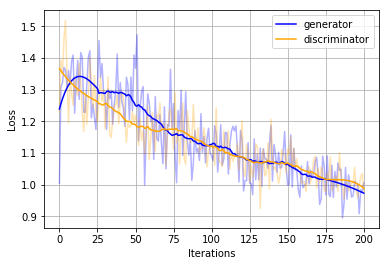

In [27]:
#%matplotlib notebook
plt.plot(np.array(log["g_loss"])[:,0], alpha=0.3,c="b")
plt.plot(np.array(log["d_loss"]),alpha=0.3, c="orange")

#plt.plot(np.array(log["g_loss"])[:,1], alpha=0.9,c="green", label="L1 objective")

plt.plot(src.smooth(np.array(log["g_loss"])[:,0]),c="b", label="generator")
plt.plot(src.smooth(np.array(log["d_loss"])),c="orange", label="discriminator")
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("sGAN_training_curves_r")


## Save network weights and log

In [56]:
name = "sgan_4-1"

In [47]:
predictions = generator.predict(gan_test)

In [48]:
scores = src.calculate_skill_scores(predictions, gan_test_truth, gan_test, 0.3)

In [51]:
for key in list(scores.keys()):
    log[key] = scores[key]

In [64]:
np.save("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings/"+name+"/"+name, log) 

In [65]:
combined.save_weights("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings/"+name+"/"+name)

# Some visualisation

In [53]:
np.mean(scores["corr_to_truth"])

0.7522755633928455

In [54]:
np.mean(scores["corr_to_input"])

1.5669899952792217

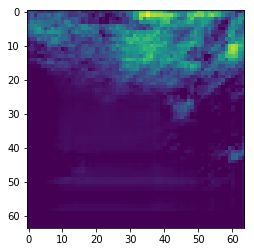

In [43]:
#%matplotlib notebook
plt.imshow(predictions[0,:,:,0], vmin=0)

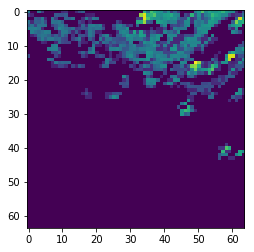

In [44]:
#%matplotlib notebook
plt.imshow(gan_test_truth[0,:,:,0], vmin=0)

In [ ]:
scores = src.calculate_skill_scores(predictions, gan_test_truth, gan_test, 0.3)

In [ ]:
np.mean(scores["corr_to_input"])

In [ ]:
np.mean(scores["corr_to_truth"])

In [ ]:
scores.keys()

In [ ]:
np.mean(scores["csi"])

In [ ]:
np.mean(scores["far"])

In [ ]:
np.mean(scores["pod"])

In [ ]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
    has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
    GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
    the discriminator wants to make the distance between its output for real and generated samples as large as possible.
    The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
    0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be) less than 0."""
    return K.mean(y_true * y_pred)

In [ ]:
def noisy_d_labels(real, fake):
    # idea: https://arxiv.org/pdf/1606.03498.pdf
    batch_size = len(real)
    five_percent = int(0.05*batch_size)
    idx = np.random.randint(0, batch_size, five_percent)
    d_real = np.ones_like(real)
    d_fake = np.zeros_like(fake)
    d_real[idx] = 0
    d_fake[idx] = 1
    return d_real, d_fake